In [ ]:
from pathlib import Path
import matplotlib.style
import matplotlib as mpl
import torch

DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)
mpl.style.use("default")

checkpoint = torch.load('./model.pt')

fig_path = Path("/home/jan/Uni/master/data/created_figures/feedforward/FeedForward/MaskedLossWeight")
fig_path.mkdir(parents=True, exist_ok=True)


In [ ]:
from maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    bin_size=1
    # antibiotics= ['Ciprofloxacin', 'Ceftriaxone', "Cefepime", "Piperacillin-Tazobactam", "Tobramycin"]
)

driams.loading_type = "memory"

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size

gen = torch.Generator()

train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator= gen.manual_seed(SEED))

driams

Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
driams.label_stats

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,...,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
positive,1068,13366,8578,21966,628,618,4223,7383,2338,3470,...,1205,5537,12431,7616,486,580,244,3534,1707,227
negative,20941,24992,4194,4905,456,457,5813,31567,4382,24566,...,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
n_sum,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,...,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=6000, output_dim=len(driams.selected_antibiotics))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=6000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=38, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
model = model.to(DEVICE)
model.eval()

test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

(0.9290355443954468, 0.8993473915677321)


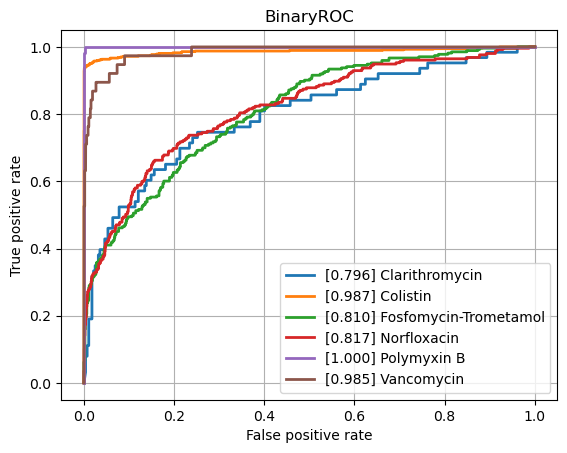

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.8649491667747498, 0.7616200192194236)


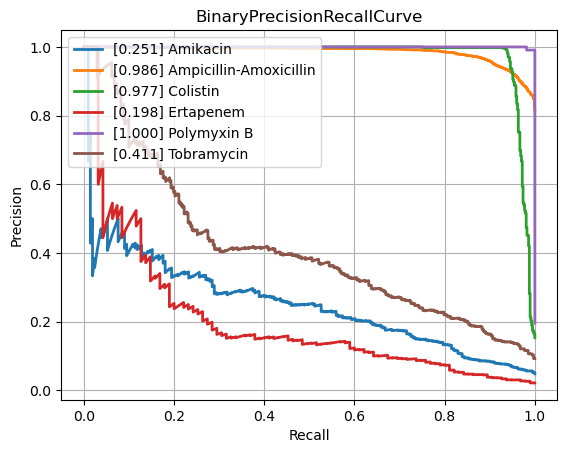

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
test_features.shape

torch.Size([11156, 6000])

In [ ]:
split1,split2 = torch.chunk(test_features, 2)
combined =torch.add(split1 , split2)
combined_features = torch.div(combined, 2)

split1,split2 = torch.chunk(test_labels, 2)
combined =torch.add(split1 , split2)
combined_labels = torch.div(combined, 2)
combined_labels[combined_labels == 0.5] =1

In [ ]:
output = model(combined_features)

OutOfMemoryError: CUDA out of memory. Tried to allocate 88.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 315.88 MiB is free. Including non-PyTorch memory, this process has 4.09 GiB memory in use. Of the allocated memory 3.86 GiB is allocated by PyTorch, and 70.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./ROC_combined_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_combined_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./PR_combined_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_combined_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()